In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from sklearn.cluster import MiniBatchKMeans
import glob


In [ ]:
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
fish_folder = r"C:\Users\96650\Downloads\archive (4)\fish_image"

# Convert dataset to DataFrame
def convert_to_df(ds):
    image_paths, labels = [], []
    # loop through the 23 subfolders (fish1, fish2, ..., fish23)
    for folder in sorted(os.listdir(ds)):
        folder_path = os.path.join(ds, folder)
        if os.path.isdir(folder_path):
            label_name = folder  # e.g. "fish1"
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(folder_path, file))
                    labels.append(label_name)
    return pd.DataFrame({'image_path': image_paths, 'label': labels})


# convert fish folders into dataframes
fish_df = convert_to_df(fish_folder)


# check results
print(f"✅ Loaded {len(fish_df)} total images")
print("Number of classes:", fish_df['label'].nunique())
print("Classes:", fish_df['label'].unique())

✅ Loaded 27731 total images
Number of classes: 23
Classes: ['fish_01' 'fish_02' 'fish_03' 'fish_04' 'fish_05' 'fish_06' 'fish_07'
 'fish_08' 'fish_09' 'fish_10' 'fish_11' 'fish_12' 'fish_13' 'fish_14'
 'fish_15' 'fish_16' 'fish_17' 'fish_18' 'fish_19' 'fish_20' 'fish_21'
 'fish_22' 'fish_23']


In [10]:
# ORB Feature Extraction
orb = cv2.ORB_create(nfeatures=500)

def extract_orb_features(fish_folder):
    img = cv2.imread(fish_folder, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros(128)  # handle missing images
    img = cv2.resize(img, (128, 128))
    keypoints, descriptors = orb.detectAndCompute(img, None)
    if descriptors is not None:
        # take mean of descriptors to get fixed-length vector
        return descriptors.mean(axis=0)
    else:
        # if no keypoints found
        return np.zeros(32)

features = []
for path in fish_df['image_path']:
    features.append(extract_orb_features(path))

X = np.array(features)
y = np.array(fish_df['label'])

print("✅ ORB feature shape:", X.shape)

✅ ORB feature shape: (27731, 32)


Selected Images:
- C:\Users\96650\Downloads\archive (4)\fish_image\fish_04\fish_003555135480_13654.png
- C:\Users\96650\Downloads\archive (4)\fish_image\fish_12\fish_003571805521_20321.png
- C:\Users\96650\Downloads\archive (4)\fish_image\fish_01\fish_004126006756_16447.png


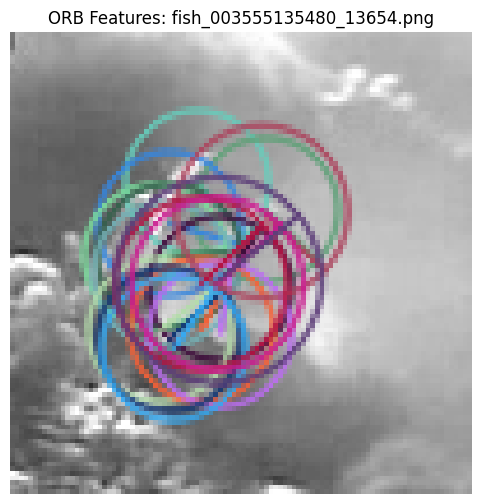

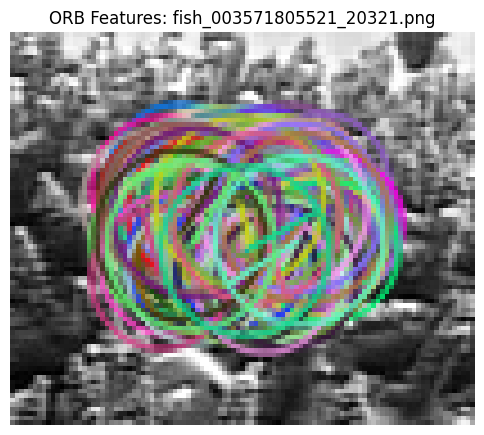

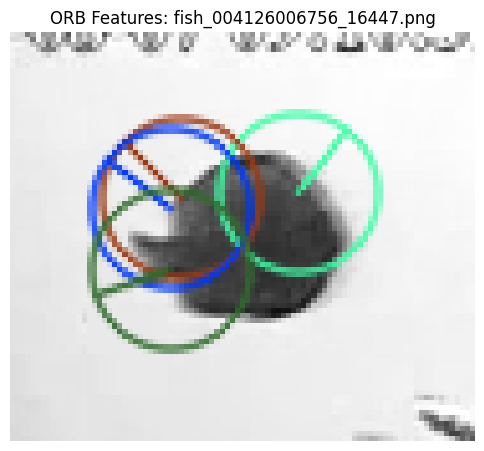

In [ ]:

import matplotlib.pyplot as plt
import random


# 1. Pick 3 random images from the dataset

def pick_three_images(fish_folder):
    all_images = []
    for root, dirs, files in os.walk(fish_folder):
        for f in files:
            if f.endswith(('.jpg', '.png', '.jpeg')):
                all_images.append(os.path.join(root, f))

    return random.sample(all_images, 3)



# 2. Visualize ORB Keypoints 

def visualize_orb_features(image_path, max_features=500):
    # Load grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Create ORB detector
    orb = cv2.ORB_create(nfeatures=max_features)

    # Detect keypoints & descriptors
    keypoints, descriptors = orb.detectAndCompute(img, None)

    # Draw keypoints on image
    img_with_kp = cv2.drawKeypoints(
        img,
        keypoints,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img_with_kp, cmap='gray')
    plt.title(f"ORB Features: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()



# 3. Run the visualization


selected_images = pick_three_images(fish_folder)
print("Selected Images:")
for img in selected_images:
    print("-", img)

for img_path in selected_images:
    visualize_orb_features(img_path)


Split the dataset to training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [ ]:

# 5-FOLD CROSS VALIDATION and Store predictions per fold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

metrics = {
    "SVM": {"acc": [], "preds": [], "truth": []},
    "KNN": {"acc": [], "preds": [], "truth": []},
    "ANN": {"acc": [], "preds": [], "truth": []}
}

fold = 1

for train_idx, test_idx in skf.split(X, y):
    print(f"\n==================== FOLD {fold} ====================")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "SVM": SVC(kernel="rbf"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "ANN": MLPClassifier(hidden_layer_sizes=(256,128),
                             activation="relu",
                             solver="adam",
                             max_iter=40,
                             random_state=42)
    }

    for model_name, model in models.items():
        print(f"\n---- {model_name} ----")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        metrics[model_name]["acc"].append(acc)
        metrics[model_name]["preds"].append(y_pred)
        metrics[model_name]["truth"].append(y_test)

        print("Fold Accuracy:", acc)

    fold += 1



==================== FOLD 1 ====================

---- SVM ----
Fold Accuracy: 0.7564449251847846

---- KNN ----
Fold Accuracy: 0.7079502433747972

---- ANN ----
Fold Accuracy: 0.7678024157202091

==================== FOLD 2 ====================

---- SVM ----
Fold Accuracy: 0.7618103137396322

---- KNN ----
Fold Accuracy: 0.7131265777136675

---- ANN ----
Fold Accuracy: 0.7713667508113956

==================== FOLD 3 ====================

---- SVM ----
Fold Accuracy: 0.7486476739992788

---- KNN ----
Fold Accuracy: 0.7044716913090515

---- ANN ----
Fold Accuracy: 0.7627118644067796

==================== FOLD 4 ====================

---- SVM ----
Fold Accuracy: 0.7636134150739271

---- KNN ----
Fold Accuracy: 0.7091597547782186

---- ANN ----
Fold Accuracy: 0.7706455102776776

==================== FOLD 5 ====================

---- SVM ----
Fold Accuracy: 0.7628921745402092

---- KNN ----
Fold Accuracy: 0.709700685178507

---- ANN ----
Fold Accuracy: 0.7659574468085106



 BEST FOLD RESULTS FOR ANN 
Best Fold Index: 2
Best Accuracy: 0.7713667508113956

Classification Report:

              precision    recall  f1-score   support

     fish_01       0.83      0.86      0.84      2423
     fish_02       0.62      0.57      0.59       536
     fish_03       0.82      0.84      0.83       719
     fish_04       0.79      0.81      0.80       810
     fish_05       0.71      0.77      0.74       506
     fish_06       0.50      0.16      0.24        38
     fish_07       0.51      0.67      0.58        90
     fish_08       0.52      0.32      0.39        44
     fish_09       0.68      0.54      0.60        48
     fish_10       0.80      0.85      0.82        60
     fish_11       0.27      0.15      0.19        20
     fish_12       0.47      0.24      0.32        29
     fish_13       0.36      0.14      0.20        36
     fish_14       0.67      0.33      0.44        18
     fish_15       0.71      0.31      0.43        16
     fish_16       0.65     

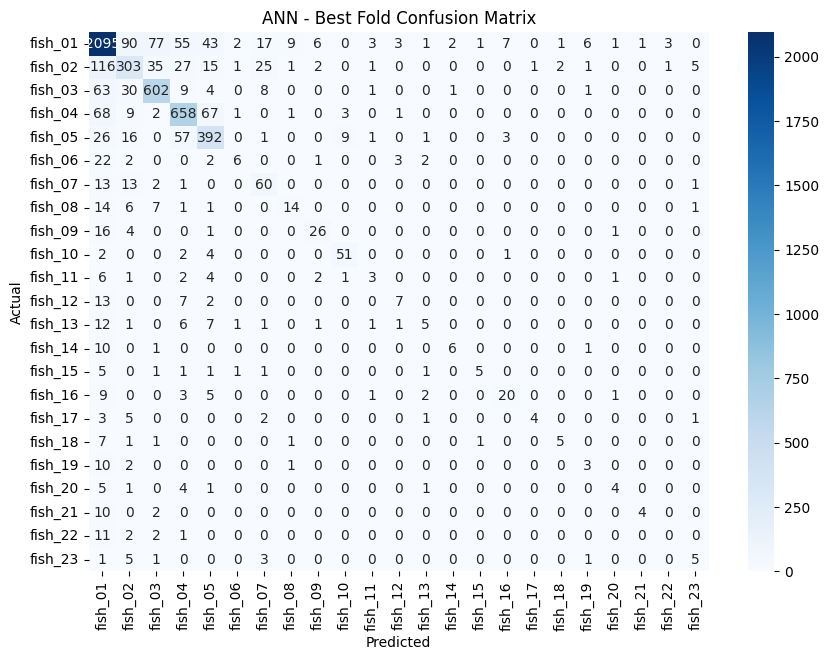


 BEST FOLD RESULTS FOR KNN 
Best Fold Index: 2
Best Accuracy: 0.7131265777136675

Classification Report:

              precision    recall  f1-score   support

     fish_01       0.70      0.91      0.79      2423
     fish_02       0.72      0.15      0.25       536
     fish_03       0.86      0.68      0.76       719
     fish_04       0.69      0.86      0.77       810
     fish_05       0.73      0.64      0.68       506
     fish_06       0.44      0.11      0.17        38
     fish_07       0.82      0.26      0.39        90
     fish_08       0.71      0.11      0.20        44
     fish_09       0.35      0.46      0.40        48
     fish_10       0.68      0.93      0.79        60
     fish_11       0.33      0.15      0.21        20
     fish_12       0.68      0.59      0.63        29
     fish_13       0.00      0.00      0.00        36
     fish_14       1.00      0.11      0.20        18
     fish_15       1.00      0.19      0.32        16
     fish_16       0.65     

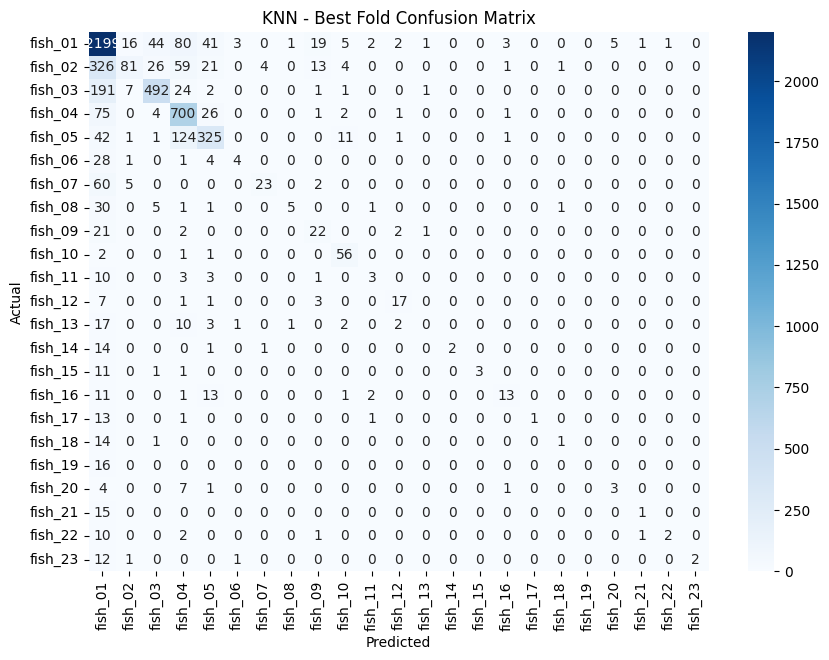


 BEST FOLD RESULTS FOR SVM 
Best Fold Index: 4
Best Accuracy: 0.7636134150739271

Classification Report:

              precision    recall  f1-score   support

     fish_01       0.76      0.93      0.84      2422
     fish_02       0.65      0.47      0.55       537
     fish_03       0.85      0.81      0.83       718
     fish_04       0.77      0.86      0.81       810
     fish_05       0.74      0.68      0.71       507
     fish_06       0.00      0.00      0.00        38
     fish_07       0.49      0.39      0.43        90
     fish_08       1.00      0.09      0.17        44
     fish_09       1.00      0.25      0.40        48
     fish_10       0.94      0.77      0.84        60
     fish_11       0.00      0.00      0.00        19
     fish_12       0.00      0.00      0.00        30
     fish_13       0.00      0.00      0.00        36
     fish_14       0.00      0.00      0.00        18
     fish_15       0.00      0.00      0.00        16
     fish_16       1.00     

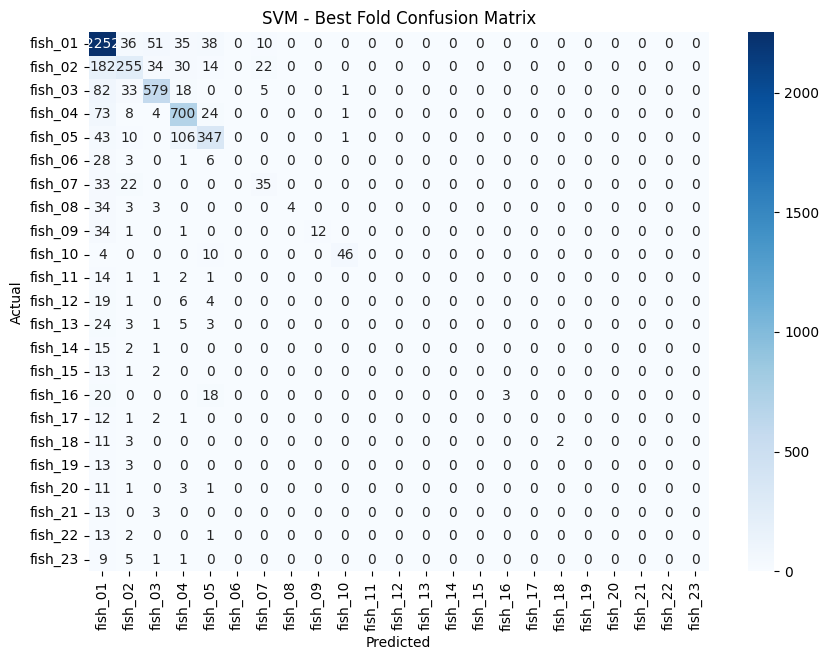

In [ ]:

# BEST FOLD REPORT AND CONFUSION MATRIX FOR EACH MODEL

def show_results_for_best_fold(model_name):
    print("\n============================================")
    print(f" BEST FOLD RESULTS FOR {model_name} ")
    print("============================================")

    # Find index of best fold
    best_fold = np.argmax(metrics[model_name]["acc"])
    best_acc = metrics[model_name]["acc"][best_fold]

    print(f"Best Fold Index: {best_fold + 1}")
    print(f"Best Accuracy: {best_acc}")

    y_true = metrics[model_name]["truth"][best_fold]
    y_pred = metrics[model_name]["preds"][best_fold]

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Best Fold Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Show best fold results
show_results_for_best_fold("ANN")
show_results_for_best_fold("KNN")
show_results_for_best_fold("SVM")
